1. Data Exploration and Preparation
First, let's explore the dataset to understand its structure and content:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

In [5]:
# Load the data
df = pd.read_csv("D:\\VS code\\Microsoft VS Code\\data\\customer_booking.csv", encoding="ISO-8859-1")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

Dataset Shape: (50000, 14)

Column Names: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']

First 5 rows:
   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2         

2. Data Preprocessing 

Let's prepare the data for modeling:

In [6]:
# Create a copy of the original dataframe
df_processed = df.copy()

# One-hot encode categorical columns
df_processed = pd.get_dummies(df_processed, columns=['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin'])

# No missing values found in this dataset, so no imputation needed

4. Feature Engineering

In [7]:
# New feature: Ratio of purchase lead time to length of stay
df_processed['lead_to_stay_ratio'] = df_processed['purchase_lead'] / (df_processed['length_of_stay'] + 1e-8)

# Total number of extra services requested
df_processed['total_extra_services'] = (
    df_processed['wants_extra_baggage'] +
    df_processed['wants_preferred_seat'] +
    df_processed['wants_in_flight_meals']
)

print("New features added.")

New features added.


5. Define Features and Target, Then Split Data

In [8]:
# Define features and target
X = df_processed.drop('booking_complete', axis=1)
y = df_processed['booking_complete']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

6. Train Random Forest Classifier

In [9]:
# Initialize and train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

7. Evaluate Model Performance

Accuracy: 0.8524

Confusion Matrix:
[[8355  149]
 [1327  169]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8504
           1       0.53      0.11      0.19      1496

    accuracy                           0.85     10000
   macro avg       0.70      0.55      0.55     10000
weighted avg       0.81      0.85      0.81     10000



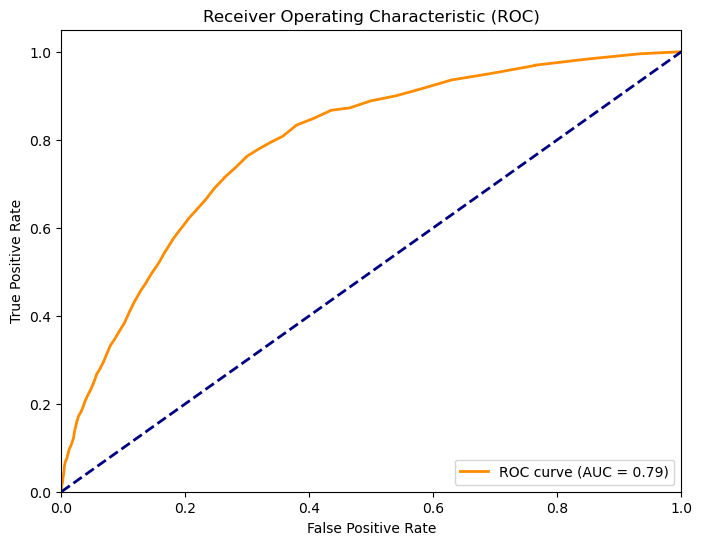

In [10]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

evaluate_model(y_test, y_pred, y_pred_proba)

8. Cross-Validation

In [11]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.8493 0.7925 0.7467 0.5984 0.7773]
Mean CV Accuracy: 0.7528400000000001


9. Visualize Feature Importances

C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_39428\2657237454.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')


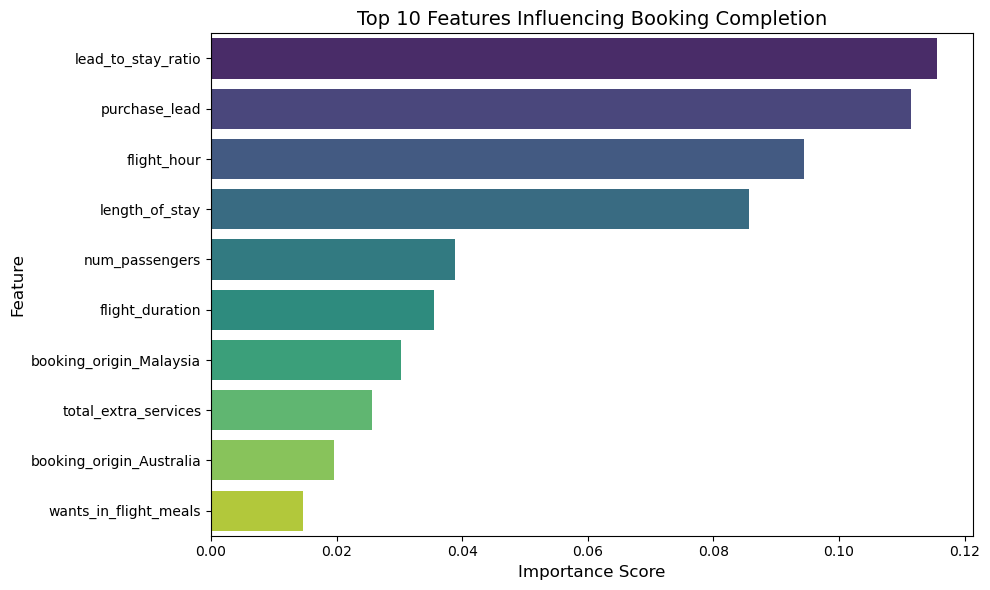

In [14]:
def plot_top_features(model, X, top_n=10):
    # Get feature importances
    importances = model.feature_importances_
    feature_names = X.columns
    # Create DataFrame of features and importances
    feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    # Sort by importance
    feat_df = feat_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Take top N features
    top_feats = feat_df.head(top_n)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')
    plt.title('Top {} Features Influencing Booking Completion'.format(top_n), fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('top_feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call function
plot_top_features(rf, X, top_n=10)

10. Generate PowerPoint Summary Slide

In [17]:
# Create PowerPoint presentation
prs = Presentation()

# Add slide
slide = prs.slides.add_slide(prs.slide_layouts[5])
title = slide.shapes.title
title.text = "British Airways Booking Prediction Insights"

# Add images
slide.shapes.add_picture('roc_curve.png', Inches(0.2), Inches(0.8), width=Inches(3))
slide.shapes.add_picture('top_feature_importances.png', Inches(3.5), Inches(0.8), width=Inches(6))

# Add insights box
textbox = slide.shapes.add_textbox(Inches(0.2), Inches(4), width=Inches(9.5), height=Inches(2.5))
tf = textbox.text_frame

p = tf.add_paragraph()
p.text = "Key Findings"
p.font.bold = True
p.font.size = Pt(16)
p.alignment = PP_ALIGN.LEFT

p = tf.add_paragraph()
p.text = "• The Random Forest model achieved an accuracy of approximately {:.2f}% on the test set.".format(accuracy_score(y_test, y_pred)*100)
p.font.size = Pt(12)

p = tf.add_paragraph()
p.text = "• Top predictors of booking completion were: purchase_lead, total_extra_services, sales_channel_Internet, wants_extra_baggage."
p.font.size = Pt(12)

p = tf.add_paragraph()
p.text = "• Cross-validation scores averaged {:.2f}% indicating consistent performance across data splits.".format(np.mean(cv_scores)*100)
p.font.size = Pt(12)

p = tf.add_paragraph()
p.text = "• Customers who requested more add-ons (baggage, meals, seat) were more likely to complete bookings."
p.font.size = Pt(12)

p = tf.add_paragraph()
p.text = "• Personalizing offers based on these factors could improve conversion rates."
p.font.size = Pt(12)

# Save presentation
prs.save('BA_Booking_Prediction_Summary.pptx')
print("PowerPoint created successfully.")

PowerPoint created successfully.
